## Interest rate simulation code

In [1]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Input, Dense, Conv2D, Concatenate, Dropout, Subtract, \
                        Flatten, MaxPooling2D, Multiply, Lambda, Add, Dot, RNN, Softmax, Dot
from keras.activations import relu
from keras.backend import constant
from keras import optimizers
from keras.engine.topology import Layer
from keras.models import Model
from keras.layers import Input
from keras import initializers
from keras.constraints import max_norm
import keras.backend as K
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import copy


In [2]:
# TIME GRID

N=12*20
time_grid_plain=np.linspace(0,N,N+1)
time_grid_dcc=time_grid_plain/12 # day-count-convention


In [3]:
# YIELD CURVE PARAMETERS

index_yc=2135 # 31-Dec-2012

# YIELD CURVE DYNAMICS

# data import
path=''
ECB=pd.read_csv(path+'201231_ECB.csv')

# zero-coupon bond prices for maturity T in years and Svensson parameter z
def ZCB_prices(T,z):
    return np.exp(-1/100*(z[0]*T-(z[1]/z[4]+z[2]/z[4]**2)*(np.exp(-z[4]*T)-1)-\
        z[2]/z[4]*T*np.exp(-z[4]*T)-z[3]/z[5]*T*np.exp(-z[5]*T)-z[3]/z[5]**2*\
        (np.exp(-z[5]*T)-1)))

# historical discount factors for a time grid
vec_ZCB_prices=np.vectorize(ZCB_prices,excluded=[1])

# yields for historical day i
def hist_yc(i,grid=time_grid_dcc[1:],rating='AAA'):
    shift=0 if rating=='AAA' else 6
    z=[ECB.loc[i,:][1+shift],ECB.loc[i,:][2+shift],ECB.loc[i,:][3+shift]/\
        ECB.loc[i,:][5+shift],ECB.loc[i,:][4+shift]/ECB.loc[i,:][6+shift],1/\
        ECB.loc[i,:][5+shift],1/ECB.loc[i,:][6+shift]]
    return np.divide(-np.log(vec_ZCB_prices(grid,z)),grid)

# collection of historical yields
def vec_hist_yc(i,grid=time_grid_dcc[1:],rating='AAA'):
    output=hist_yc(i[0],grid,rating)
    for j in i[1:]:
        output=np.vstack((output,hist_yc(j,grid,rating)))
    return output

# transform yields into discount factors
def discounting(yields,terms):
    return np.exp(-yields*terms)

# PCA
hist_increments=vec_hist_yc(range(1,index_yc))-vec_hist_yc(range(0,index_yc-1))
PCA_mu=np.mean(hist_increments,axis=0)
PCA_Q=np.cov(hist_increments,rowvar=False)
PCA_lambda,PCA_Lambda=np.linalg.eig(PCA_Q)
PCA_lambda,PCA_Lambda=np.real(PCA_lambda),np.real(PCA_Lambda)
#print(np.cumsum(PCA_lambda)[:10]/np.sum(PCA_lambda))

# generate a new yield curve increment
def yc_scn_gen(n=3,PCA_mu=PCA_mu,PCA_Lambda=PCA_Lambda,PCA_lambda=PCA_lambda):
    return 22*PCA_mu+np.matmul(PCA_Lambda[:,:n],np.random.multivariate_normal(\
        np.zeros(n),np.diag(22*PCA_lambda[:n])).reshape(n,1)).flatten()

# YIELD CURVE OBJECTS

class yc:
    def __init__(self,yields):
        self.yields=yields
        self.dfs=discounting(yields,time_grid_dcc[1:])
    
    def cpn(self,tenor,maturity):
        return 12/tenor*(1-self.dfs[maturity-1])/np.sum(self.dfs[np.arange(\
            tenor,maturity+tenor,tenor)-1])
    
    def pv(self,cash_flows):
        return np.dot(self.dfs,cash_flows)
    
    def update(self,new_yields):
        self.yields=new_yields
        self.dfs=discounting(new_yields,time_grid_dcc[1:])

## Swaps

In [4]:

# we concern only vanilla swaps
#  One party pays floating interest, LIBOR 
#  Other party pays the fixed rate, does not worry about movements 
class swap:
    # exchange floating over tenor
    # one party pays floating 
    # other pays fixed rate every month 
    def __init__(self,yc,nominal,maturity,tenor=1): #tenor=1
        self.yc=yc
        self.nominal=nominal #how much money is involved
        self.maturity=maturity # maybe need to be a
        self.montly_cost = yc.cpn(1,self.maturity)
        self.fixed_leg=np.append(np.repeat(self.montly_cost,
            self.maturity),np.repeat(np.zeros(1),N-self.maturity))/12 #*tenor
        # \the fixed cost
        # cash 

    def update(self,steps=1):
        self.maturity-=steps
        # maybe not use, how is it adjusted over roll forward.
        self.fixed_leg=np.append(self.fixed_leg[steps:],np.zeros(steps))


def swap_indicator(maturity):
    # show when do payments due in more general swaps.
    return np.reshape(np.append(np.ones(maturity),np.zeros(N-maturity)),(1,N))

#Our bank will decide to sell og get a swap. 
# Task of deep hedging: Find a swap float to stable

## Objective

In [5]:
# Possible investements
swap_series=[24,60,120,240]

# BALANCE SHEET PARAMETERS
# assets
A0=100
# liabilities (constant deposits)
L0=50
# Fine to be paied if the total swap volume so that it is less than assets*spending_limit
penalty=0.2 # of the assets over the spending limit
spending_limit = 0.8

# OPTIMISATION PARAMETERS
target_month=120
# loss function
target_equity=70
# size of training and validation set
nScenarios=10**3
nValidation=10**3
# The four maturities we can go into at any time


## Do nothing bank (benchmark):

In [6]:
# Over the next 10 year i do nothing 
# Assets will be componded with the montly rate 
# Liabilities will be constant 

def benchmark(nRoutines=nValidation):
    output=np.zeros(nRoutines)
    for l in range(nRoutines):
        # yield curve
        Y=yc(hist_yc(index_yc))
        # assets
        A_pre=A0
        A_post=A0
        L=L0
        E=(A0-L0)
        for k in range(target_month):
            # market updates
            A_pre*=np.exp(Y.yields[0]/12)
            Y=yc(Y.yields+yc_scn_gen())
            A_post=A_pre
            L=L
            E=A_post-L
        output[l]=E
    return output

In [7]:
#test
Y=yc(hist_yc(index_yc))
np.exp(Y.yields[0]/12)-1, Y.cpn(1,1)/12

(5.8862566218564893e-05, 5.886256621861179e-05)

## Deep portifolio optimization for the swap market 

In [8]:
# netwok parameters
network_params = {"n_hidden_layers": 3, "neurons": 30}


In [9]:
# Generate training and testing data 
def get_swap_rate_array(sets,months,swap_series):
    swap_rate_array = np.zeros((sets, months, len(swap_series)))
    for k in range(sets):
        current_yealds = hist_yc(index_yc)
        for m in range(months):
            for s, swap_length in enumerate(swap_series):
                # Not completly sure if this is calculated correctly
                swap_rate_array[k][m][s] = yc(current_yealds).cpn(1, swap_length) / 12
            current_yealds += yc_scn_gen()
    return swap_rate_array


def get_current_rate_array(sets,months):
    current_rate_array = np.zeros((sets, months, 1))
    for k in range(sets):
        current_yealds = hist_yc(index_yc)
        for m in range(months):
            # Not completly sure if this is calculated correctly
            current_rate_array[k][m] = current_yealds[0]
            current_yealds += yc_scn_gen()
    return current_rate_array


In [10]:
# Generating this test data takes some time 

# training data
inputs = [
    get_swap_rate_array(nScenarios,target_month,swap_series),
    get_current_rate_array(nScenarios,target_month),
]
xtrain = inputs 
ytrain = [np.zeros((nScenarios, 1)), np.zeros((nScenarios, 1))]

# testing data
inputs_test = [
    get_swap_rate_array(nScenarios,target_month,swap_series),
    get_current_rate_array(nScenarios,target_month),
]
xtest = inputs_test 
ytest= [np.zeros((nValidation, 1)), np.zeros((nValidation, 1))]


Here we define the decision network that will act in each cell of the RNN. Right now it makes decitions only based on the amout of assets

In [11]:
class SwapDecisionCell(Layer):
    def __init__(self, swap_series, n_hidden_layers, neurons, months, **kwargs):
        self.months = months
        self.max_swap = max(swap_series)
        self.swap_series = swap_series

        # Number of output dimensions m
        # strategy are all the possible strategies exept 1 moth wich is the rest
        self.output_dimension = len(swap_series)
        # Number of neurons per layer
        self.neurons = neurons
        # Number of hidden layers
        self.n_hidden_layers = n_hidden_layers
        # Activation function
        self.activation = "tanh"  # might shange this later

        self.input_layer = Dense(
            self.neurons,
            activation=self.activation,
            trainable=True,
            kernel_initializer=initializers.RandomNormal(
                0, 1
            ),  # kernel_initializer='random_normal',
            bias_initializer="random_normal",
            name="input",
        )
        self.hidden_layers = [
            Dense(
                neurons,
                activation=self.activation,
                trainable=True,
                kernel_initializer=initializers.RandomNormal(
                    0, 1
                ),  # kernel_initializer='random_normal',
                bias_initializer="random_normal",
                name=f"hidden_{i}",
            )
            for i in range(n_hidden_layers)
        ]

        self.output_layer = Dense(
            self.output_dimension,
            activation=self.activation,
            trainable=True,
            kernel_initializer=initializers.RandomNormal(
                0, 0.1
            ),  # kernel_initializer='random_normal',
            bias_initializer="random_normal",
            name="input",
        )
        # states are: equity, month, fixed_cash_flows and swap_volume
        self.state_size = [
            1,
            self.max_swap,  # + max(swap_series) is a hack so that we allways can buy the swaps we want
            self.max_swap,
        ]

        # For now equity and swap wolume for each timestep
        self.output_size = [1, 1]
        super(SwapDecisionCell, self).__init__(**kwargs)

    def get_initial_state(self, inputs=None, batch_size=None, dtype=None):
        # TODO: This is not a good way to initialize the state but other ways do not seem to work 
        return (
            # Warning this is a global variable :(
            A0 * tf.ones([batch_size, 1]),
            tf.zeros([batch_size, self.max_swap]),
            tf.zeros([batch_size, self.max_swap]),
        )

    def call(self, inputs, states):
        ############
        #  Decicion step: time = t
        ############
        assets, fixed_cash_flows, swap_volume = states
        # there is probably some better word than current rate
        # TODO: incorporate prices here? with Concatenate
        swap_rates, current_rate = inputs

        # compute the strategy
        # strategy is a list of nominals for each swap. Zero nominal meeans no swap  
        strategy = self.input_layer(assets)
        for layer in self.hidden_layers:
            strategy = layer(strategy)
        strategy = self.output_layer(strategy)

        # Update with our strategy
        for s, swap_length in enumerate(swap_series):
            
            # make a tensor with the strategy for swap s, that is as long as the swap period
            swaps = tf.tile(strategy[:, s : s + 1], [1, swap_length])
            
            # filler 
            zeros = (
                tf.tile(strategy[:, s : s + 1], [1, self.max_swap - swap_length]) * 0
            )

            # fill the rest of the tensor with zeros 
            new_swap_volume_s = tf.concat([swaps, zeros], axis=1)

            swap_volume += new_swap_volume_s
            fixed_cash_flows += new_swap_volume_s * swap_rates[:, s : s + 1]

        #############
        #  Result step:  time = t + 1
        #############

        # the money in the bank gets interst and has to pay interest on the swaps
        assets += (assets - swap_volume[:, 0:1]) * (tf.math.exp(current_rate / 12) - 1)

        # the bank gets cash from the swaps
        assets += fixed_cash_flows[:, 0:1]
        output = (assets, swap_volume[:,0:1])

        # update the swap to reflect time has passed
        swap_volume = tf.concat([swap_volume[:, 1:], 0 * swap_volume[:, 0:1]], 1)
        fixed_cash_flows = tf.concat(
            [fixed_cash_flows[:, 1:], 0 * fixed_cash_flows[:, 0:1]], 1
        )

        new_states = (assets, fixed_cash_flows, swap_volume)

        return output, new_states


In [12]:
# Define network input, None is the  batch size, which is not yet specified.
input_swap_rates = Input(shape=(None, 4))
input_current_rate = Input(shape=(None, 1))

#define a cell that will be used within the RNN
cell = SwapDecisionCell(swap_series=swap_series, months=target_month, **network_params )

#feed the cell into the RNN
rnn_bank_model = RNN(cell,return_sequences=True)

outputs = rnn_bank_model((input_swap_rates, input_current_rate))
bank_model = Model([input_swap_rates, input_current_rate], outputs)


Here some loss functions are defined. By plaing around with the parameters we see that the `penalty` term as a big effect. Penalties are probably not calculated exactly this way, but it was easy to code. 

In [13]:
_penalty = penalty

#trying out different penalties
_penalty = 0.0

# loss function
def loss_with_penalty(y_true, y_pred):
    assets = y_pred[0]
    final_assets = assets[-1]
    swap_volume = y_pred[1]
    # calulate penalty 
    penalties = tf.math.reduce_sum(relu(tf.abs(swap_volume) - assets * spending_limit))* _penalty
    # penelize if the final equity is less than target equity (thats why the relu is there )
    return K.mean(relu(-(final_assets - penalties - L0 - target_equity)) ** 2)

def loss_without_penalty(y_true, y_pred):
    assets = y_pred[0]
    final_assets = assets[-1]
    # penelize if the final equity is less than target equity
    return K.mean(relu(-(final_assets  - L0 - target_equity)) ** 2)


In [14]:
adam=optimizers.Adam(lr=0.01)
bank_model.compile(optimizer=adam,loss=loss_with_penalty)


In [15]:
for i in range(1):
    bank_model.fit(x=xtrain,y=ytrain, epochs=40,verbose=True,batch_size=100)

Epoch 1/40
10/10 [==============================] - 19s 83ms/step - loss: 8836.9381 - rnn_loss: 1331.9663 - rnn_1_loss: 7504.9718
Epoch 2/40
10/10 [==============================] - 1s 112ms/step - loss: 220.7526 - rnn_loss: 220.7526 - rnn_1_loss: 0.0000e+00
Epoch 3/40
10/10 [==============================] - 1s 93ms/step - loss: 37.5593 - rnn_loss: 37.5593 - rnn_1_loss: 0.0000e+00
Epoch 4/40
10/10 [==============================] - 1s 91ms/step - loss: 142.9650 - rnn_loss: 142.9650 - rnn_1_loss: 0.0000e+00
Epoch 5/40
10/10 [==============================] - 1s 123ms/step - loss: 120.4576 - rnn_loss: 120.4576 - rnn_1_loss: 0.0000e+00
Epoch 6/40
10/10 [==============================] - 1s 80ms/step - loss: 28.2249 - rnn_loss: 28.2249 - rnn_1_loss: 0.0000e+00
Epoch 7/40
10/10 [==============================] - 1s 80ms/step - loss: 528.3466 - rnn_loss: 528.3466 - rnn_1_loss: 0.0000e+00
Epoch 8/40
10/10 [==============================] - 1s 80ms/step - loss: 138.8166 - rnn_loss: 138.8166 -

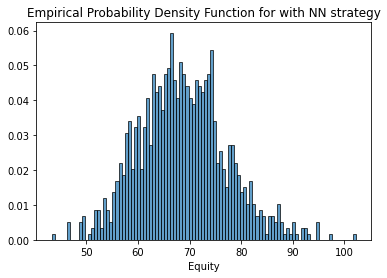

In [17]:
assets, swap_volume =bank_model.predict(xtest) 
equities_nn = assets[:,-1] -L0 -tf.math.reduce_sum(relu(tf.abs(swap_volume) - assets * spending_limit), axis=-2)* _penalty
plt.hist(equities_nn.numpy(),bins=100,density=True,edgecolor='black',alpha=0.7)
plt.title(f'Empirical Probability Density Function for with NN strategy, penalty = {_penalty}')
plt.xlabel('Equity')
plt.show()

Some interesting results is that penalty size plays a big part in determining the total swap value over time. Try it out by plaing with the data 

In [ ]:

for i in range(100):
    plt.plot(swap_volume[i]/assets[i])
plt.title(f'The relative swap volume over time, penalty={_penalty}')
plt.ylabel('Relative swap volume')
plt.xlabel('Month')
plt.show()
    

In [ ]:
for i in range(100):
    plt.plot(assets[i]-L=)
plt.title(f'Bank eqity over time, penalty={_penalty}')
plt.xlabel('Relative swap volume')
plt.xlabel('Month')
plt.show()